# CNNMNIST for OpticalNeuralNetwork test manual

author:Yuzhe Zhang

date: 2024 0901

# TEST01

### 1.导入必要包

In [220]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import confusion_matrix 
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image

### 2.下载数据集

In [158]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]) #归一 

In [162]:
train_dataset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)  
test_dataset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)   
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

### 3.定义模型

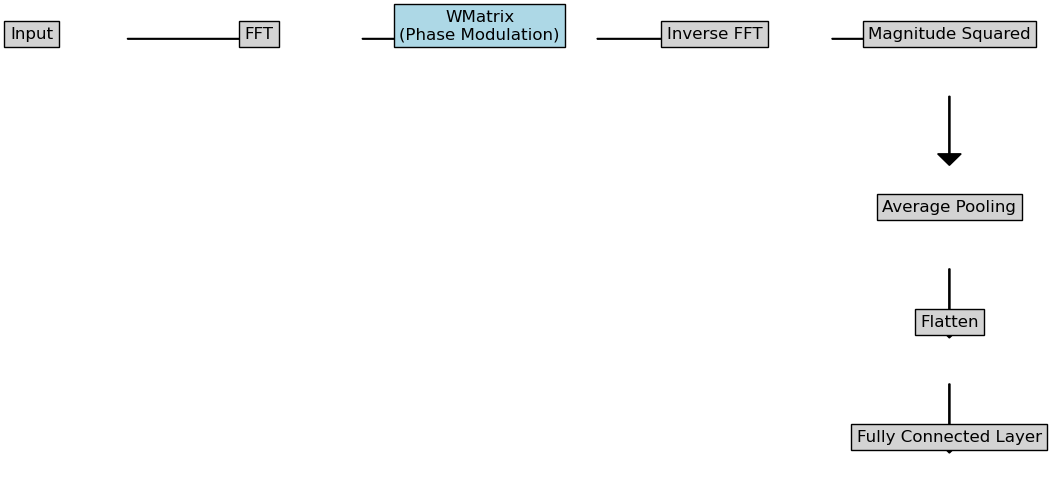

In [479]:
# 示意图
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey

def draw_model_diagram():
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.axis('off')
    plt.text(0.1, 0.8, 'Input', fontsize=12, bbox=dict(facecolor='lightgray', edgecolor='black'))
    plt.text(0.3, 0.8, 'FFT', fontsize=12, bbox=dict(facecolor='lightgray', edgecolor='black'))
    plt.text(0.5, 0.8, 'WMatrix\n(Phase Modulation)', fontsize=12, bbox=dict(facecolor='lightblue', edgecolor='black'), ha='center')
    plt.text(0.7, 0.8, 'Inverse FFT', fontsize=12, bbox=dict(facecolor='lightgray', edgecolor='black'), ha='center')
    plt.text(0.9, 0.8, 'Magnitude Squared', fontsize=12, bbox=dict(facecolor='lightgray', edgecolor='black'), ha='center')

    plt.text(0.9, 0.5, 'Average Pooling', fontsize=12, bbox=dict(facecolor='lightgray', edgecolor='black'), ha='center')
    plt.text(0.9, 0.3, 'Flatten', fontsize=12, bbox=dict(facecolor='lightgray', edgecolor='black'), ha='center')
    plt.text(0.9, 0.1, 'Fully Connected Layer', fontsize=12, bbox=dict(facecolor='lightgray', edgecolor='black'), ha='center')
  
    plt.arrow(0.2, 0.8, 0.1, 0, head_width=0.02, head_length=0.02, fc='black', ec='black')
    plt.arrow(0.4, 0.8, 0.1, 0, head_width=0.02, head_length=0.02, fc='black', ec='black')
    plt.arrow(0.6, 0.8, 0.1, 0, head_width=0.02, head_length=0.02, fc='black', ec='black')
    plt.arrow(0.8, 0.8, 0.1, 0, head_width=0.02, head_length=0.02, fc='black', ec='black')

    plt.arrow(0.9, 0.7, 0, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    plt.arrow(0.9, 0.4, 0, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')
    plt.arrow(0.9, 0.2, 0, -0.1, head_width=0.02, head_length=0.02, fc='black', ec='black')

    plt.show()

draw_model_diagram()


In [431]:
class WMatrix(nn.Module):
    def __init__(self, size):
        super(WMatrix, self).__init__()
        self.size = size
        self.W = nn.Parameter(torch.randint(0, 256, (size, size)).float())  # Parameter，可训练
        self.W_phase = None

    def forward(self, fft_image):
        self.W_phase = self.W / 255.0 * 2 * np.pi  # 归一化到[0, 2π]
        phase_shift = torch.exp(1j * self.W_phase)  # 生成相位调制 
       # weight = torch.as_complex(weight)
        modulated_fft = fft_image * phase_shift  # 调制
        return modulated_fft

class CustomFFTModel(nn.Module):
    def __init__(self, size):
        super(CustomFFTModel, self).__init__()
        self.w_matrix = WMatrix(size)
        # 计算池化后的尺寸 
        self.fc_input_dim = (size // 2) * (size // 2)  #  2x2的池化
        self.fc = nn.Linear(self.fc_input_dim, 10)  # 10 是 MNIST 类别数
    def forward(self, x):
        # 将输入转为频域
        x_fft = torch.fft.fft2(x)
        # 应用W矩阵
        x_modulated = self.w_matrix(x_fft)
        # 逆FFT
        x_ifft = torch.fft.ifft2(x_modulated)
        # 计算模方
        x_mag_squared = torch.abs(x_ifft) ** 2
          # --- CMOS之后的事情 ---
        # Pooling
        x_pooled = F.avg_pool2d(x_mag_squared, 2)
        # Flatten
        x_flat = x_pooled.view(x_pooled.size(0), -1)  # 展平
        # fully connect
        x_out = self.fc(x_flat)

        return x_out 

### 4.训练

In [181]:
model = CustomFFTModel(28)

In [183]:
criterion = torch.nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/10], Loss: 0.6835, Accuracy: 89.84%
Epoch [2/10], Loss: 0.3754, Accuracy: 91.08%
Epoch [3/10], Loss: 0.3280, Accuracy: 91.20%
Epoch [4/10], Loss: 0.3054, Accuracy: 91.90%
Epoch [5/10], Loss: 0.2915, Accuracy: 91.95%
Epoch [6/10], Loss: 0.2823, Accuracy: 91.99%
Epoch [7/10], Loss: 0.2748, Accuracy: 92.00%
Epoch [8/10], Loss: 0.2704, Accuracy: 92.10%
Epoch [9/10], Loss: 0.2652, Accuracy: 92.42%
Epoch [10/10], Loss: 0.2614, Accuracy: 92.37%


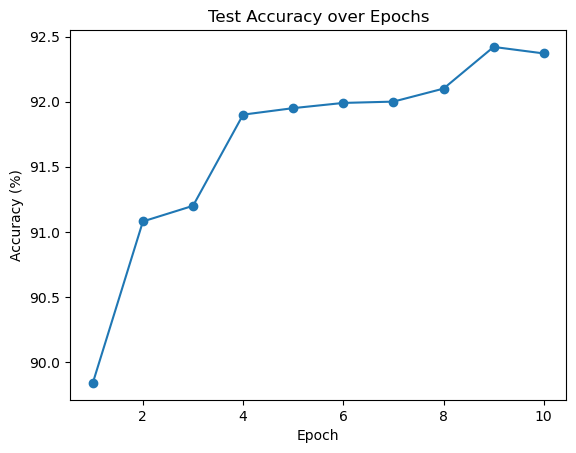

In [185]:
accuracy_list = []
 
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        accuracy = test_model(model, test_loader)
        accuracy_list.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

# 测试模型
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# 训练和测试
train_model(model, train_loader, test_loader, criterion, optimizer)

# 绘制准确率曲线
plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.show()

### 5.保留并画出权重W矩阵、评价混淆矩阵

In [191]:
torch.save(model.state_dict(), 'model_complex_in_frequency.pth')

In [201]:
 for name, param in model.state_dict().items():
    print(f"Parameter name: {name}")
    print(param)
    print()

Parameter name: w_matrix.W
tensor([[ 81., 176., 216., 246., 168., 211.,  39., 228.,  36., 150., 134., 227.,
         243., 171., 100.,   2.,   9., 210.,  98.,  27., 230., 193., 173., 119.,
         107.,  37., 254., 166.],
        [ 58.,  88., 217., 236., 223., 143.,  13., 100., 169., 180.,  54.,  79.,
          93., 106., 244., 157., 102., 211., 134., 172., 144.,   7., 223., 247.,
         117., 114.,  38., 100.],
        [ 15., 217.,  56., 161., 212.,  36.,  51., 171., 108.,  26., 252., 150.,
          51., 103., 236.,  82.,  88., 130.,  87.,  78., 187., 197.,  31., 119.,
          34., 196., 193., 249.],
        [193.,  74.,  42., 249., 205.,  82., 218.,  70.,  10., 233.,  75.,  27.,
          20.,   9., 192., 129.,  96.,  56., 103., 180.,  47., 221., 198.,  49.,
         238.,  74., 110.,  95.],
        [168., 173.,  58., 235., 241., 206., 171.,  61., 131.,  25.,  11.,   9.,
         152., 227.,   6., 164., 225., 234., 107., 179., 195.,  48., 145., 229.,
         227., 162.,  17., 

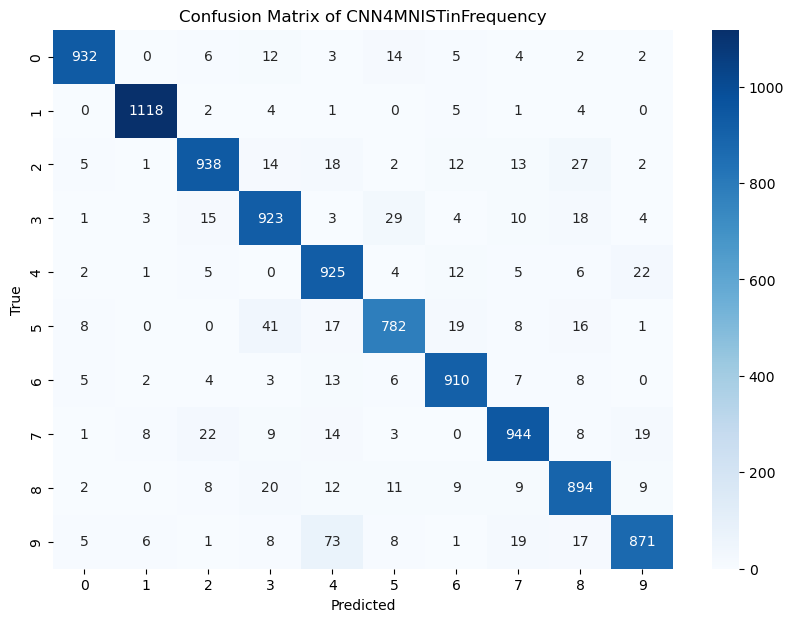

In [209]:
model.eval()   
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 生成混淆矩阵并画图
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix of CNN4MNISTinFrequency')
plt.show()

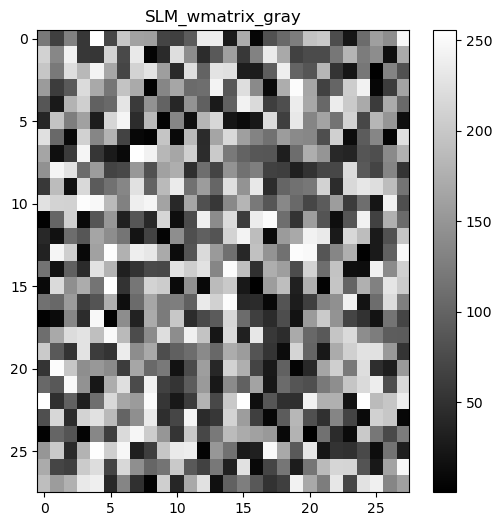

In [248]:
weight_matrix_8bit = model.w_matrix.W.detach().cpu().numpy()

plt.figure(figsize=(6, 6))
plt.imshow(weight_matrix_8bit, cmap='gray', aspect='auto')
plt.colorbar()
plt.title("SLM_wmatrix_gray")
plt.show()

image = Image.fromarray(weight_matrix_8bit, mode='L')   
image.save('SLM_wmatrix_gray.bmp')

### 6.选择一个测试集的图片测一下

In [250]:
index = 1 

#### 6.1测试在光学系统内的变化

In [280]:
sample, _ = test_dataset[index]  
sample = sample.squeeze(0)  # 去掉 batch，得到 [28, 28]
# FFT{}
sample_fft = torch.fft.fft2(sample)
# W \odot
model = CustomFFTModel(size=28)
model.load_state_dict(torch.load('model_complex_in_frequency.pth'))
w_matrix = model.w_matrix
sample_modulated = w_matrix(sample_fft)
# iFFT{}
sample_ifft = torch.fft.ifft2(sample_modulated)
# .^2
sample_mag_squared = torch.abs(sample_ifft) ** 2

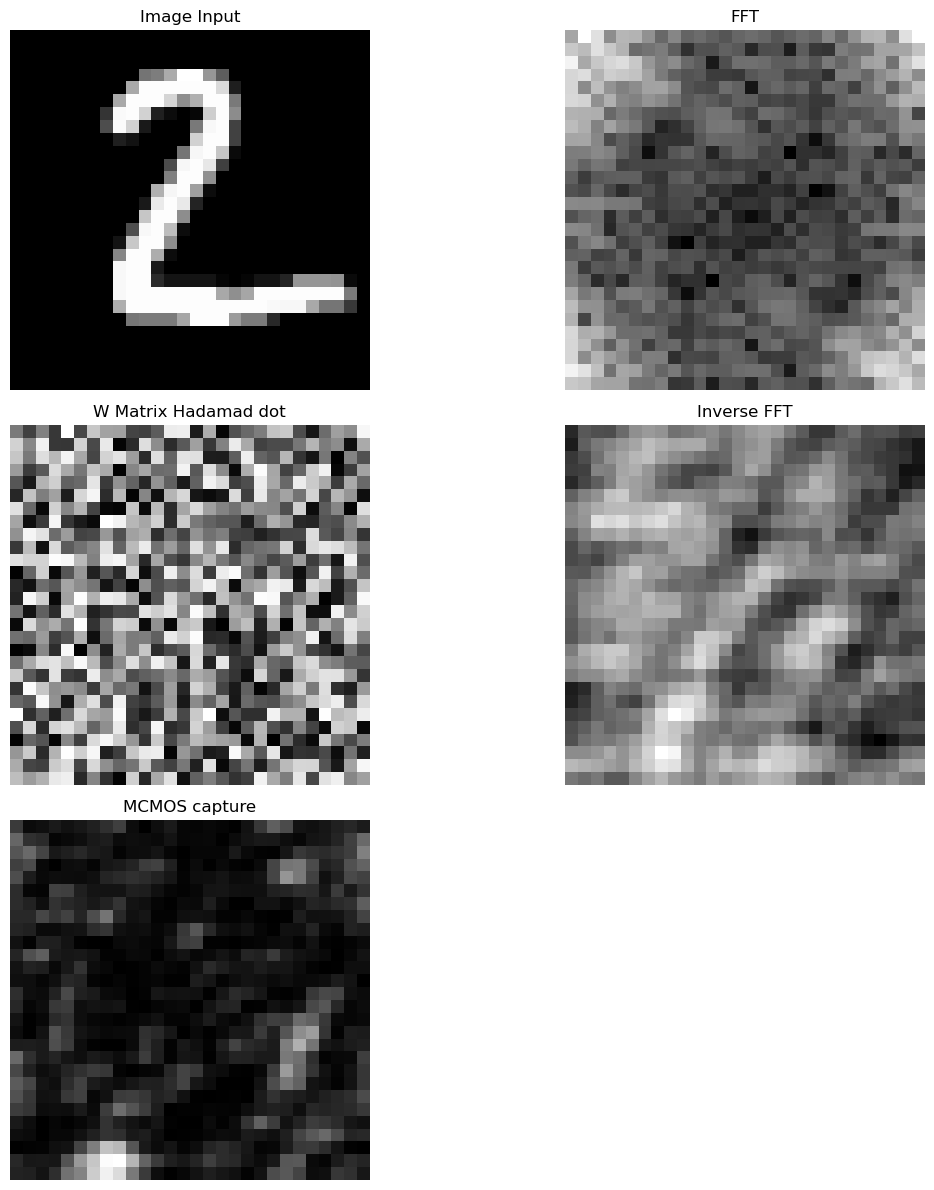

In [274]:
plt.figure(figsize=(12, 12))
# input
plt.subplot(3, 2, 1)
plt.imshow(sample.cpu().numpy(), cmap='gray')
plt.title("Image Input")
plt.axis('off')
# FFT
plt.subplot(3, 2, 2)
plt.imshow(np.log(torch.abs(sample_fft).cpu().numpy() + 1), cmap='gray')
plt.title("FFT")
plt.axis('off')
# W
plt.subplot(3, 2, 3)
plt.imshow(w_matrix.W.detach().cpu().numpy(), cmap='gray')
plt.title("W Matrix Hadamad dot")
plt.axis('off')
# iFFT{}
plt.subplot(3, 2, 4)
plt.imshow(sample_ifft.real.detach().cpu().numpy(), cmap='gray')
plt.title("Inverse FFT")
plt.axis('off')
# .^2
plt.subplot(3, 2, 5)
plt.imshow(sample_mag_squared.real.detach().cpu().numpy(), cmap='gray')
plt.title("MCMOS capture")
plt.axis('off')
#---
plt.tight_layout()
plt.show()

#### 6.2测试拍完CMOS之后的计算机内处理历经

In [292]:
sample, _ = test_dataset[index]   
sample = sample.unsqueeze(0)

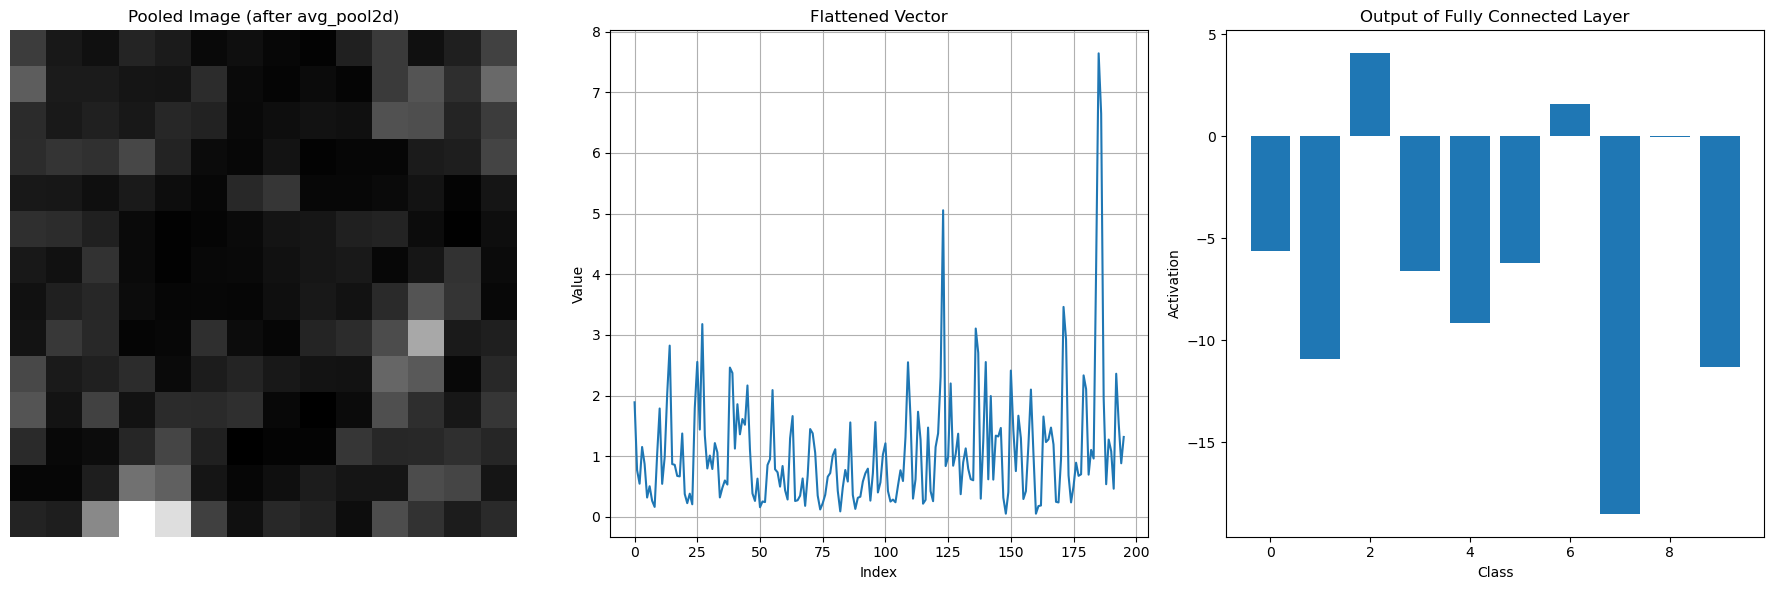

In [294]:
with torch.no_grad():
    # after CMOS
    x_fft = torch.fft.fft2(sample)
    x_modulated = model.w_matrix(x_fft)
    x_ifft = torch.fft.ifft2(x_modulated)
    x_mag_squared = torch.abs(x_ifft) ** 2
    # Pooling
    x_pooled = F.avg_pool2d(x_mag_squared, 2)
    # Flatten
    x_flat = x_pooled.view(x_pooled.size(0), -1)  
    # FC
    x_out = model.fc(x_flat)

# plot
plt.figure(figsize=(18, 6))
# Pooling
plt.subplot(1, 3, 1)
plt.imshow(x_pooled.squeeze().cpu().numpy(), cmap='gray')
plt.title("Pooled Image (after avg_pool2d)")
plt.axis('off')
# Flatten
plt.subplot(1, 3, 2)
plt.plot(x_flat.squeeze().cpu().numpy())
plt.title("Flattened Vector")
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)
# FC （fc本身就带着W和bias 激活）
plt.subplot(1, 3, 3)
plt.bar(range(10), x_out.squeeze().cpu().numpy())
plt.title("Output of Fully Connected Layer")
plt.xlabel("Class")
plt.ylabel("Activation")

plt.tight_layout()
plt.show() 

### 7.样本复杂度对模型表达的影响

In [301]:
# 上面训练的模型数目很多，有可能大力出奇迹
# 不信请看
print(f"Number of images in the training set: { len(train_dataset)}")
print(f"Number of images in the test set: {len(test_dataset)}")

Number of images in the training set: 60000
Number of images in the test set: 10000


#### 7.1 10000 train 10000 test

In [307]:
# 想检验一下我的model结构对于小数据集是否有robust
import torch
from torch.utils.data import Subset 
 
# train_dataset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)
# test_dataset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)

# 从train中随机选择 10,000 张图片
subset_indices = np.random.choice(len(train_dataset), 10000, replace=False) 
train_subset = Subset(train_dataset, subset_indices)

# 创建新的DataLoader
new_train_loader = torch.utils.data.DataLoader(dataset=train_subset, batch_size=64, shuffle=True)
new_test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [309]:
new_model = CustomFFTModel(28)

Epoch [1/10], Loss: 1.3294, Accuracy: 82.29%
Epoch [2/10], Loss: 0.7127, Accuracy: 85.93%
Epoch [3/10], Loss: 0.5631, Accuracy: 87.70%
Epoch [4/10], Loss: 0.4903, Accuracy: 88.72%
Epoch [5/10], Loss: 0.4442, Accuracy: 89.08%
Epoch [6/10], Loss: 0.4108, Accuracy: 89.55%
Epoch [7/10], Loss: 0.3869, Accuracy: 89.85%
Epoch [8/10], Loss: 0.3705, Accuracy: 89.98%
Epoch [9/10], Loss: 0.3537, Accuracy: 90.06%
Epoch [10/10], Loss: 0.3402, Accuracy: 90.61%


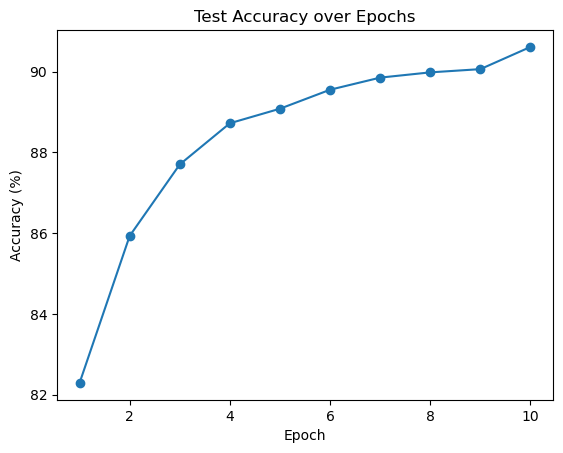

In [313]:
new_criterion = torch.nn.CrossEntropyLoss() 
new_optimizer = optim.Adam(new_model.parameters(), lr=0.001)

new_accuracy_list = []
def new_train_model(new_model, new_train_loader, new_test_loader, new_criterion, new_optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        new_model.train()
        running_loss = 0.0
        for images, labels in new_train_loader:
            new_optimizer.zero_grad()

            outputs = new_model(images)
            loss = new_criterion(outputs, labels)
            loss.backward()
            new_optimizer.step()

            running_loss += loss.item()

        accuracy = new_test_model(new_model, new_test_loader)
        new_accuracy_list.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(new_train_loader):.4f}, Accuracy: {accuracy:.2f}%')

def new_test_model(new_model, new_test_loader):
    new_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in new_test_loader:
            outputs = new_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

 
new_train_model(new_model, new_train_loader, new_test_loader, new_criterion, new_optimizer)
 
plt.plot(range(1, len(new_accuracy_list) + 1), new_accuracy_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.show()

In [329]:
torch.save(new_model.state_dict(), 'new_model_complex_in_frequency.pth')

#### 7.2 1000 train 10000 test

In [319]:
# train_dataset = datasets.MNIST(root='./data/mnist', train=True, download=True, transform=transform)
# test_dataset = datasets.MNIST(root='./data/mnist', train=False, download=True, transform=transform)

# 从train中随机选择 1000 张图片
subset_indices1000 = np.random.choice(len(train_dataset), 1000, replace=False) 
train_subset1000 = Subset(train_dataset, subset_indices1000)
renew_train_loader = torch.utils.data.DataLoader(dataset=train_subset1000, batch_size=64, shuffle=True)
renew_test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [321]:
renew_model = CustomFFTModel(28)

Epoch [1/10], Loss: 2.4335, Accuracy: 23.59%
Epoch [2/10], Loss: 2.0361, Accuracy: 44.14%
Epoch [3/10], Loss: 1.7341, Accuracy: 59.66%
Epoch [4/10], Loss: 1.5113, Accuracy: 68.67%
Epoch [5/10], Loss: 1.3447, Accuracy: 72.82%
Epoch [6/10], Loss: 1.2070, Accuracy: 75.10%
Epoch [7/10], Loss: 1.1070, Accuracy: 77.67%
Epoch [8/10], Loss: 1.0234, Accuracy: 78.56%
Epoch [9/10], Loss: 0.9522, Accuracy: 79.70%
Epoch [10/10], Loss: 0.8991, Accuracy: 80.19%


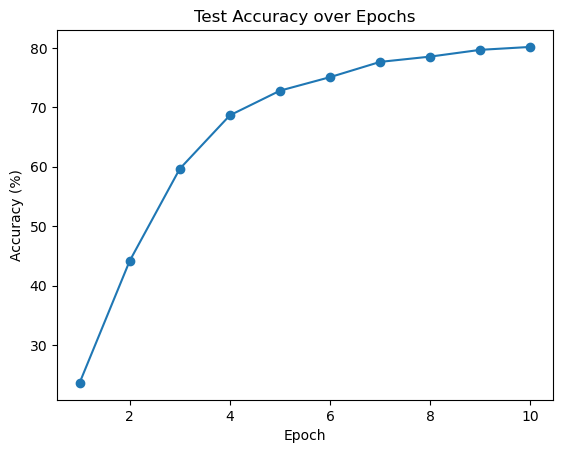

In [325]:
renew_criterion = torch.nn.CrossEntropyLoss() 
renew_optimizer = optim.Adam(renew_model.parameters(), lr=0.001)

renew_accuracy_list = []
def renew_train_model(renew_model, renew_train_loader, renew_test_loader, renew_criterion, renew_optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        renew_model.train()
        running_loss = 0.0
        for images, labels in renew_train_loader:
            renew_optimizer.zero_grad()

            outputs = renew_model(images)
            loss = renew_criterion(outputs, labels)
            loss.backward()
            renew_optimizer.step()

            running_loss += loss.item()

        accuracy = renew_test_model(renew_model, renew_test_loader)
        renew_accuracy_list.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(renew_train_loader):.4f}, Accuracy: {accuracy:.2f}%')

def renew_test_model(renew_model, renew_test_loader):
    renew_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in renew_test_loader:
            outputs = renew_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

 
renew_train_model(renew_model, renew_train_loader, renew_test_loader, renew_criterion, renew_optimizer)
 
plt.plot(range(1, len(renew_accuracy_list) + 1), renew_accuracy_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.show()

In [353]:
torch.save(renew_model.state_dict(), 'renew_model_complex_in_frequency.pth')

#### 7.3 train 1000  test 1000

In [358]:
train_subset1000 = Subset(train_dataset, np.random.choice(len(train_dataset), 1000, replace=False))
rrenew_train_loader = torch.utils.data.DataLoader(dataset=train_subset1000, batch_size=64, shuffle=True)
test_subset1000 = Subset(test_dataset, np.random.choice(len(test_dataset), 1000, replace=False))
rrenew_test_loader = torch.utils.data.DataLoader(dataset=test_subset1000, batch_size=64, shuffle=False)

In [360]:
rrenew_model = CustomFFTModel(28)

Epoch [1/10], Loss: 2.2545, Accuracy: 29.80%
Epoch [2/10], Loss: 1.8987, Accuracy: 55.50%
Epoch [3/10], Loss: 1.6363, Accuracy: 64.30%
Epoch [4/10], Loss: 1.4354, Accuracy: 68.90%
Epoch [5/10], Loss: 1.2813, Accuracy: 73.00%
Epoch [6/10], Loss: 1.1668, Accuracy: 74.30%
Epoch [7/10], Loss: 1.0672, Accuracy: 76.50%
Epoch [8/10], Loss: 0.9964, Accuracy: 77.80%
Epoch [9/10], Loss: 0.9335, Accuracy: 78.90%
Epoch [10/10], Loss: 0.8708, Accuracy: 79.80%


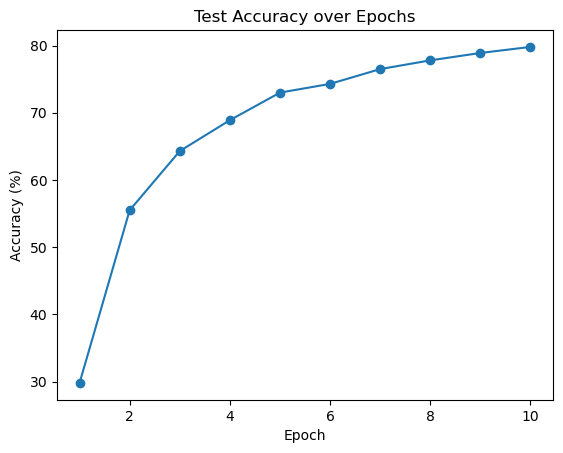

In [362]:
rrenew_criterion = torch.nn.CrossEntropyLoss() 
rrenew_optimizer = optim.Adam(rrenew_model.parameters(), lr=0.001)

rrenew_accuracy_list = []
def rrenew_train_model(rrenew_model, rrenew_train_loader, rrenew_test_loader, rrenew_criterion, rrenew_optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        rrenew_model.train()
        running_loss = 0.0
        for images, labels in rrenew_train_loader:
            rrenew_optimizer.zero_grad()

            outputs = rrenew_model(images)
            loss = rrenew_criterion(outputs, labels)
            loss.backward()
            rrenew_optimizer.step()

            running_loss += loss.item()

        accuracy = rrenew_test_model(rrenew_model, rrenew_test_loader)
        rrenew_accuracy_list.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(rrenew_train_loader):.4f}, Accuracy: {accuracy:.2f}%')

def rrenew_test_model(rrenew_model, rrenew_test_loader):
    rrenew_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in rrenew_test_loader:
            outputs = rrenew_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

 
rrenew_train_model(rrenew_model, rrenew_train_loader, rrenew_test_loader, rrenew_criterion, rrenew_optimizer)
 
plt.plot(range(1, len(rrenew_accuracy_list) + 1), rrenew_accuracy_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.show()

In [364]:
torch.save(rrenew_model.state_dict(), 'rrenew_model_complex_in_frequency.pth')

#### 7.4 600 train 100test

Epoch [1/10], Loss: 2.3450, Accuracy: 12.00%
Epoch [2/10], Loss: 2.1098, Accuracy: 25.00%
Epoch [3/10], Loss: 1.8969, Accuracy: 38.00%
Epoch [4/10], Loss: 1.7044, Accuracy: 47.00%
Epoch [5/10], Loss: 1.5531, Accuracy: 56.00%
Epoch [6/10], Loss: 1.4301, Accuracy: 58.00%
Epoch [7/10], Loss: 1.3199, Accuracy: 62.00%
Epoch [8/10], Loss: 1.2206, Accuracy: 63.00%
Epoch [9/10], Loss: 1.1451, Accuracy: 65.00%
Epoch [10/10], Loss: 1.0581, Accuracy: 63.00%


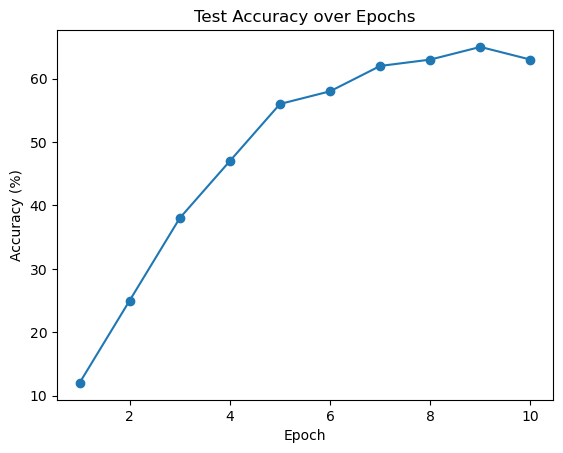

In [373]:
train_subset600 = Subset(train_dataset, np.random.choice(len(train_dataset), 600, replace=False))
rrrenew_train_loader = torch.utils.data.DataLoader(dataset=train_subset600, batch_size=64, shuffle=True)
test_subset100 = Subset(test_dataset, np.random.choice(len(test_dataset), 100 , replace=False))
rrrenew_test_loader = torch.utils.data.DataLoader(dataset=test_subset100, batch_size=64, shuffle=False)

rrrenew_model = CustomFFTModel(28)

rrrenew_criterion = torch.nn.CrossEntropyLoss() 
rrrenew_optimizer = optim.Adam(rrrenew_model.parameters(), lr=0.001)

rrrenew_accuracy_list = []
def rrrenew_train_model(rrrenew_model, rrrenew_train_loader, rrrenew_test_loader, rrrenew_criterion, rrrenew_optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        rrrenew_model.train()
        running_loss = 0.0
        for images, labels in rrrenew_train_loader:
            rrrenew_optimizer.zero_grad()

            outputs = rrrenew_model(images)
            loss = rrrenew_criterion(outputs, labels)
            loss.backward()
            rrrenew_optimizer.step()

            running_loss += loss.item()

        accuracy = rrrenew_test_model(rrrenew_model, rrrenew_test_loader)
        rrrenew_accuracy_list.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(rrrenew_train_loader):.4f}, Accuracy: {accuracy:.2f}%')

def rrrenew_test_model(rrrenew_model, rrrenew_test_loader):
    rrrenew_model.eval()
    corrrect = 0
    total = 0
    with torch.no_grad():
        for images, labels in rrrenew_test_loader:
            outputs = rrrenew_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            corrrect += (predicted == labels).sum().item()

    accuracy = 100 * corrrect / total
    return accuracy

 
rrrenew_train_model(rrrenew_model, rrrenew_train_loader, rrrenew_test_loader, rrrenew_criterion, rrrenew_optimizer)
 
plt.plot(range(1, len(rrrenew_accuracy_list) + 1), rrrenew_accuracy_list, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.show()

In [375]:
torch.save(rrrenew_model.state_dict(), 'rrrenew_model_complex_in_frequency.pth')

#### 7.5 比较一下

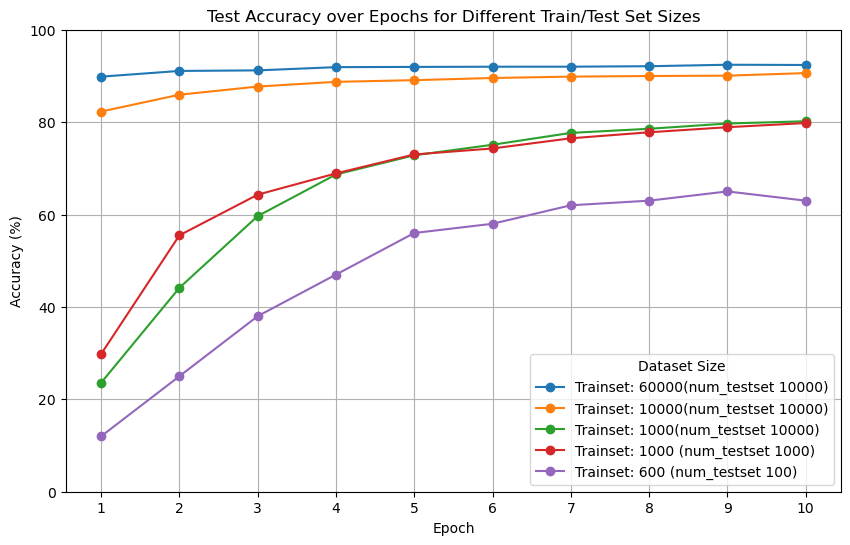

In [379]:
train_sizes = ['60000(num_testset 10000)', '10000(num_testset 10000)', '1000(num_testset 10000)', '1000 (num_testset 1000)', '600 (num_testset 100)']

accuracies = [
    [89.84, 91.08, 91.20, 91.90, 91.95, 91.99, 92.00, 92.10, 92.42, 92.37],  # trainset: 60000
    [82.29, 85.93, 87.70, 88.72, 89.08, 89.55, 89.85, 89.98, 90.06, 90.61],  # trainset: 10000
    [23.59, 44.14, 59.66, 68.67, 72.82, 75.10, 77.67, 78.56, 79.70, 80.19],  # trainset: 1000, testset: 10000
    [29.80, 55.50, 64.30, 68.90, 73.00, 74.30, 76.50, 77.80, 78.90, 79.80],  # trainset: 1000, testset: 1000
    [12.00, 25.00, 38.00, 47.00, 56.00, 58.00, 62.00, 63.00, 65.00, 63.00]   # trainset: 600, testset: 100
]

epochs = list(range(1, 11))
plt.figure(figsize=(10, 6))

for i, acc in enumerate(accuracies):
    plt.plot(epochs, acc, marker='o', label=f'Trainset: {train_sizes[i]}')

plt.title('Test Accuracy over Epochs for Different Train/Test Set Sizes')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(epochs)
plt.ylim([0, 100])
plt.grid(True)
plt.legend(title="Dataset Size")
plt.show()


# TEST02

不难观察到，上述TEST01中的`3.定义模型`部分我们的相位调制仅仅是用了模长为1的矩阵，但是这样不由让人觉得W矩阵的dimension不够，可能导致模型效果不好（这个问题为[Fang Yuetong学姐](https://scholar.google.com/citations?user=zgo7pswAAAAJ&hl=EN)指出）


因此，很自然的想法，把横模长的这个模长当作训练的一个参数，具体见下面：

In [385]:
 class WMatrix2(nn.Module):
    def __init__(self, size):
        super(WMatrix2, self).__init__()
        self.size = size
        self.W = nn.Parameter(torch.randint(0, 256, (size, size)).float())  # 相位矩阵，参数化
        self.magnitude = nn.Parameter(torch.tensor(1.0))  # 模长，参数化
        self.W_phase = None

    def forward(self, fft_image):
        # 计算相位矩阵
        self.W_phase = self.W / 255.0 * 2 * np.pi  # 将相位归一化到 [0, 2π]
        phase_shift = torch.exp(1j * self.W_phase)  # 生成相位调制

        # 将模长应用到相位调制矩阵上
        phase_shift_with_magnitude = self.magnitude * phase_shift

        # 对 FFT 图像进行相位调制
        modulated_fft = fft_image * phase_shift_with_magnitude
        return modulated_fft

class CustomFFTModel2(nn.Module):
    def __init__(self, size):
        super(CustomFFTModel2, self).__init__()
        self.w_matrix = WMatrix2(size)
        self.fc_input_dim = (size // 2) * (size // 2)  # 2x2 的池化
        self.fc = nn.Linear(self.fc_input_dim, 10)  # 10 是 MNIST 类别数

    def forward(self, x):
        # 将输入转换为频域
        x_fft = torch.fft.fft2(x)
        # 应用 W 矩阵
        x_modulated = self.w_matrix(x_fft)
        # 逆 FFT
        x_ifft = torch.fft.ifft2(x_modulated)
        # 计算模方
        x_mag_squared = torch.abs(x_ifft) ** 2
        # --- CMOS 之后的处理 ---
        # Pooling
        x_pooled = nn.functional.avg_pool2d(x_mag_squared, 2)
        # Flatten
        x_flat = x_pooled.view(x_pooled.size(0), -1)  # 展平
        # Fully Connected Layer
        x_out = self.fc(x_flat)

        return x_out


In [387]:
model2 = CustomFFTModel2(28)

In [389]:
criterion2 = torch.nn.CrossEntropyLoss() 
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

Epoch [1/10], Loss: 0.2765, Accuracy: 91.81%
Epoch [2/10], Loss: 0.2748, Accuracy: 92.00%
Epoch [3/10], Loss: 0.2730, Accuracy: 92.02%
Epoch [4/10], Loss: 0.2710, Accuracy: 92.10%
Epoch [5/10], Loss: 0.2710, Accuracy: 92.12%
Epoch [6/10], Loss: 0.2679, Accuracy: 91.80%
Epoch [7/10], Loss: 0.2658, Accuracy: 92.13%
Epoch [8/10], Loss: 0.2647, Accuracy: 92.37%
Epoch [9/10], Loss: 0.2645, Accuracy: 92.12%
Epoch [10/10], Loss: 0.2629, Accuracy: 92.12%


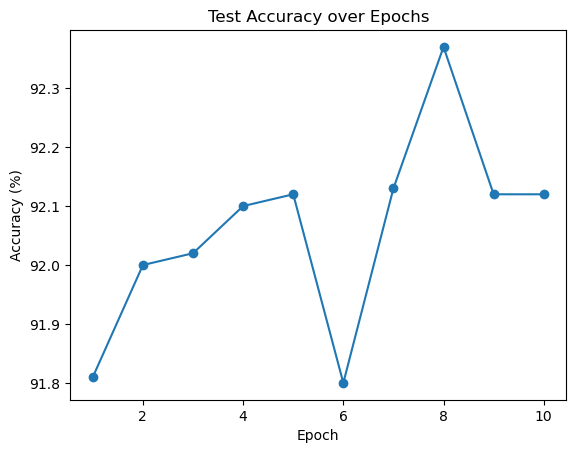

In [393]:
accuracy_list2 = []
 
def train_model2(model2, train_loader, test_loader, criterion2, optimizer2, num_epochs=10):
    for epoch in range(num_epochs):
        model2.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer2.zero_grad()

            outputs = model2(images)
            loss = criterion2(outputs, labels)
            loss.backward()
            optimizer2.step()

            running_loss += loss.item()

        accuracy = test_model2(model2, test_loader)
        accuracy_list2.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

# 测试模型
def test_model2(model2, test_loader):
    model2.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# 训练和测试
train_model2(model2, train_loader, test_loader, criterion2, optimizer2)

# 绘制准确率曲线
plt.plot(range(1, len(accuracy_list2) + 1), accuracy_list2, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.show()

In [395]:
torch.save(model2.state_dict(), 'model2_complex_in_frequency.pth')

所以其实效果并没有boost，从数学角度我们思考一下这个事情：
- 首先，这里我们把输入的图片记做矩阵 $A\in M_{28\times 28}(\mathbb{R})$，那么输出的结果可以记作：
$$\mathbf{x}_\mathbf{out}(A)=\mathrm{fc}(\mathrm{flatten}(\mathrm{pooling}(\left|F^{-1}(W\odot F(A))\right|^2)))$$
- 紧接着全连接 fc里面有一个`softmax`操作，即 
$$p_j(A)=\frac{\exp(x_j(A))}{\sum_{k=1}^C\exp(x_k(A))}$$
- 我们BP训练的时候用了下面的`criterion`，即
$$\tiny\text{CrossEntropyLoss}(A,y)=-\log(p_y(A))$$
我们要检验下面的反向传播的loss： 
$$\mathcal{L}(A,y)=-\log\left(\frac{\exp\left(\mathrm{fc}(\mathrm{flatten}(\mathrm{pooling}(\left|F^{-1}(W\odot F(A))\right|^2)))_y\right)}{\sum_{k=1}^C\exp\left(\mathrm{fc}(\mathrm{flatten}(\mathrm{pooling}(\left|F^{-1}(W\odot F(A))\right|^2)))_k\right)}\right)$$
 

- 假设将相位调制矩阵   W   替换为 \( k \cdot W \)，其中 \( k \) 是一个标量常数。我们来分析这种替换对Loss的影响:

$$
 \to = F^{-1}\left((k \cdot W) \odot F(A)\right)
$$ 
$$
F^{-1}\left((k \cdot W) \odot F(A)\right) = F^{-1}\left(k \cdot (W \odot F(A))\right)
$$
根据傅里叶逆变换的线性性质，可以将常数 $ k $ 提到外面：
$$
= k \cdot F^{-1}\left(W \odot F(A)\right)
$$
 
$$
\left| k \cdot F^{-1}\left(W \odot F(A)\right) \right|^2 
= k^2 \cdot \left| F^{-1}\left(W \odot F(A)\right) \right|^2
$$

池化操作对这个标量乘法没有影响，因为池化是基于局部均值的操作。因此：
$$
\text{Pooled Result} = k^2 \cdot \text{Pooling}\left(\left| F^{-1}(W \odot F(A)) \right|^2\right)
$$
拉平操作也是线性的，因此不会影响标量乘法：
$$
\text{Flattened Result} = k^2 \cdot \text{Flattened}\left(\text{Pooled Result}\right)
$$

假设全连接层为一个线性变换 $ \text{fc}(x) = Wx + b $，则全连接层的输出变为：
$$
\text{fc}(k^2 \cdot x) = k^2 \cdot Wx + b
$$
因此，模型输出的 logits 变为原来的 $ k^2 $ 倍。

Softmax 函数对输出的 logits 进行处理：
$$
p_j = \frac{\exp(x_j)}{\sum_{k=1}^{C} \exp(x_k)}
$$
对于经过线性放大后的 logits：
$$
p_j' = \frac{\exp(k^2 \cdot x_j)}{\sum_{k=1}^{C} \exp(k^2 \cdot x_k)}
$$
由于 $ \exp $ 函数的比例特性，所有的 `logits` 都被乘以相同的常数 $ k^2 $，在 Softmax 操作中，这个放大因子会相互抵消：
$$
p_j' = p_j
$$
这意味着 `Softmax` 输出实际上不变，即 模型的预测概率分布不会因 $ W $ 被替换为 $ k \cdot W $ 而改变。因此，交叉熵损失：
$$
\mathcal{L} = -\log(p_y)
$$
也不会因 $ W $ 被替换为 $ k \cdot W $ 而改变。


remark:从实验的角度来体会一下这个事情，如果得到两个$W$矩阵的矩阵元的元素模长不同，譬如一个为$||W_{ij}||=1$，一个为$|W_{ij}^\prime|=2$，那么是不是说我们要把一开始的光功率一个设置为$P=P_0$，另一个设置为$P^\prime=\sqrt{2}P_0$

# TEST03

由TEST01可知，我们的kernel其实是 $28\times 28$的矩阵，但是我们的SLM平面确实$1024\times 1024$的，那么我们是不是可以把图片 $28\times 28$ scaling 40倍，再按照W矩阵 scaling 40倍得到$1120\times 1120$再下采样到$1024\times 1024$吗？还是说可以先scaling30倍，然后放在中间？recall kernel mapping时的几种方法。。。

## 1. 让我们测试一下，看看精度

In [456]:
class WMatrixExpanded(nn.Module):
    def __init__(self, original_W, size):
        super(WMatrixExpanded, self).__init__()
        self.size = size
        # 扩展W矩阵
        kron_matrix = torch.ones(30, 30)
        self.W_expanded = torch.kron(original_W, kron_matrix)
        self.W_phase = None

    def forward(self, fft_image):
        self.W_phase = self.W_expanded / 255.0 * 2 * np.pi  
        phase_shift = torch.exp(1j * self.W_phase)  # 生成相位调制 
        modulated_fft = fft_image * phase_shift  # 调制
        return modulated_fft

In [459]:
# 定义处理扩展输入的网络
class CustomFFTModelExpanded(nn.Module):
    def __init__(self, original_model, size=840):
        super(CustomFFTModelExpanded, self).__init__()
        self.w_matrix_expanded = WMatrixExpanded(original_model.w_matrix.W, size)
        self.fc_input_dim = (size // 30) * (size // 30)  # 28x28 (原始输入尺寸)
        self.fc = nn.Linear(self.fc_input_dim, 10)  #  

    def forward(self, x):
        x_fft = torch.fft.fft2(x)
        x_modulated = self.w_matrix_expanded(x_fft)
        x_ifft = torch.fft.ifft2(x_modulated)
        x_mag_squared = torch.abs(x_ifft) ** 2
        # 平均池化，将 840x840 恢复为 28x28
        x_pooled = F.avg_pool2d(x_mag_squared, kernel_size=30)
        x_flat = x_pooled.view(x_pooled.size(0), -1)  
        x_out = self.fc(x_flat)
        return x_out

In [461]:
original_model = CustomFFTModel(size=28)
original_model.load_state_dict(torch.load('model_complex_in_frequency.pth'))
model_expanded = CustomFFTModelExpanded(original_model, size=840)
model_expanded.eval()

CustomFFTModelExpanded(
  (w_matrix_expanded): WMatrixExpanded()
  (fc): Linear(in_features=784, out_features=10, bias=True)
)

In [463]:
def test_model_expanded(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            # 扩展输入图像为 840x840
            kron_matrix = torch.ones(30, 30)
            images_expanded = torch.kron(images.squeeze(0), kron_matrix).unsqueeze(0)
            
            # 预测
            outputs = model(images_expanded) 
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the expanded test images: {accuracy:.2f}%')

In [467]:
test_model_expanded(model_expanded, test_loader)

Accuracy of the model on the expanded test images: 7.94%


矩阵很大，不好计算诶。。。而且精度掉的很大啊啊啊啊啊啊啊

## 2. 从数学角度谈谈 scaling

首先我们做了scaling，对input的图片$$A'=A\otimes\mathbf{1}_{30\times30}$$
 
对SLM相位调制矩阵$$W'=W\otimes\mathbf{1}_{30\times30}$$
 
调制： $$\text{Modulated}=\mathcal{F}(A')\odot\exp\left(2\pi i\frac{W'}{255}\right)$$
  
iFFT逆变换回来得到：$$\mathcal{F}^{-1}\text{ (Modulated)}$$
 
取平方得到：$$\begin{vmatrix}\mathcal{F}^{-1}\left(\text{Modulated}\right)\end{vmatrix}^2$$

这个是CMOS拍出来的$840\times 840$的 矩阵通过平均池化操作还原到$28\times28$的尺寸，得到能被CMOS后的网络部分匹配的输入:
$$\text{Pooled}=\text{AvgPool}\left(\left|\mathcal{F}^{-1}\left(\text{Modulated}\right)\right|^2,\text{kernel size}=30\right)$$  
然后输入到全连接层进行预测，得出最终的分类结果： 
$$\text{Prediction}=FC\left(\mathrm{AvgPool}\left(\left|\mathcal{F}^{-1}\left(\mathcal{F}(A\otimes\mathbf{1}_{30\times30})\odot\boldsymbol{\downarrow}\right)\left(2\pi i\frac{W\otimes\mathbf{1}_{30\times30}}{255}\right)\right)\right|^2,\text{kernel size}=30\right)$$

先不考虑Loss，因为我们只是执行了测试。从上面公式看，等我做一下化简：

---
$$
\mathcal{F}(A') = \mathcal{F}(A) \otimes \mathcal{F}(\mathbf{1}_{30 \times 30})
$$
考虑到：
$$
\mathcal{F}(\mathbf{1}_{30 \times 30}) = 30^2 \cdot \delta(f)
$$
所以
$$
\mathcal{F}(A') \approx 30^2 \cdot \mathcal{F}(A) \otimes \delta(f) = 30^2 \cdot \text{Zero-Padding}(\mathcal{F}(A))
$$
又有
$$
W' = W \otimes \mathbf{1}_{30 \times 30}
$$
结果相同，不赘述。
$$
F' = \mathcal{F}(A') \odot e^{i \phi'},I' = \left| \mathcal{F}^{-1}(F') \right|^2, I = \text{AvgPool}(I', 30)
$$
那么
$$
I \approx \left| \mathcal{F}^{-1} \left( \mathcal{F}(A) \odot e^{i \phi} \right) \right|^2 = \left| A_{\text{modulated}} \right|^2,\phi = 2\pi \frac{W}{255}
$$
所以
$$
\text{Prediction} = \text{FC}\left( \left| A_{\text{modulated}} \right|^2 \right),A_{\text{modulated}} = \mathcal{F}^{-1} \left( \mathcal{F}(A) \odot e^{i \phi} \right)
$$
化简完毕 

---
$$
\text{Prediction} = \text{FC}\left( \left| \mathcal{F}^{-1} \left( \mathcal{F}(A) \odot e^{i 2\pi \frac{W}{255}} \right) \right|^2 \right)
$$
其实严格来说，FC前面还有pooling和flatten，笔者略去了，但是仔细推敲一下，似乎并不影响。
 


## 3.直接改模型

In [ ]:
class WMatrix_test3(nn.Module):
    def __init__(self, size):
        super(WMatrix_test3, self).__init__()
        self.size = size
        self.W = nn.Parameter(torch.randint(0, 256, (size, size)).float())  
        self.W_phase = None

    def forward(self, fft_image):
        self.W_phase = self.W / 255.0 * 2 * np.pi  
        phase_shift = torch.exp(1j * self.W_phase) 
        modulated_fft = fft_image * phase_shift  
        return modulated_fft

class CustomFFTModel_test3(nn.Module):
    def __init__(self, size):
        super(CustomFFTModel_test3, self).__init__()
        self.w_matrix = WMatrix_test3(size)
        self.fc_input_dim = (size // 2) * (size // 2)  
        self.fc = nn.Linear(self.fc_input_dim, 10) 

    def forward(self, x):
        # 将输入进行 Kron  乘积操作，扩展为 840x840
        kron_matrix = torch.ones(30, 30)   
        x_expanded = torch.kron(x, kron_matrix)

        x_fft = torch.fft.fft2(x_expanded) 
        x_modulated = self.w_matrix(x_fft) 
        x_ifft = torch.fft.ifft2(x_modulated) 
        x_mag_squared = torch.abs(x_ifft) ** 2
        # --- CMOS之后的处理 --- 
        x_pooled = F.avg_pool2d(x_mag_squared, 2)
        x_flat = x_pooled.view(x_pooled.size(0), -1)  
        x_out = self.fc(x_flat)

        return x_out


model_test3 = CustomFFTModel_test3(size=840) 
criterion_test3 = nn.CrossEntropyLoss()
optimizer_test3 = optim.Adam(model_test3.parameters(), lr=0.001)
accuracy_list_test3 = []
 
def train_model_test3(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        accuracy = test_model_test3(model, test_loader)
        accuracy_list_test3.append(accuracy)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')
 
def test_model_test3(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

train_model_test3(model_test3, train_loader, test_loader, criterion_test3, optimizer_test3)
 
plt.plot(range(1, len(accuracy_list_test3) + 1), accuracy_list_test3, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Epochs')
plt.show()


太想当然，这个不可能跑出来的，或者需要跑很久，$dim(W)=840\times 840=705600$个参数量。

我手动中止了，上面的内容看起来训练四次效果还行，比之前的model都要更好。

--

Epoch [1/10], Loss: 10.1512, Accuracy: 88.60%

Epoch [2/10], Loss: 7.6715, Accuracy: 91.98%

Epoch [3/10], Loss: 7.4030, Accuracy: 93.72%

Epoch [4/10], Loss: 7.2098, Accuracy: 92.53%


In [451]:
torch.save(model_test3.state_dict(), 'model_test3complex_in_frequency.pth')

## 4.重要的问题

光学对输入作的傅里叶变换，应当是把低频分量放在中间的

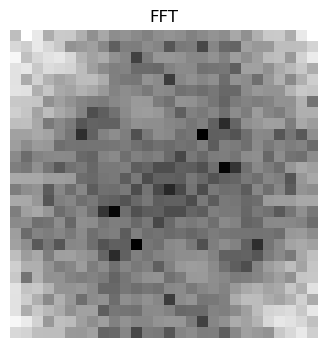

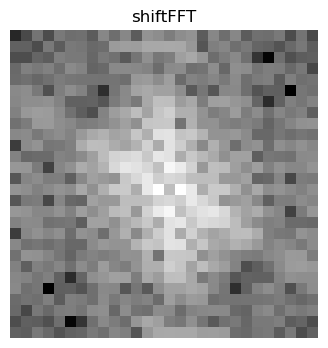

In [422]:
shifted_fft = torch.fft.fftshift(sample_fft)
 
plt.figure(figsize=(4, 4))
plt.imshow(np.log(torch.abs(sample_fft)).cpu().numpy() + 1, cmap='gray')
plt.title("FFT")
plt.axis('off')
plt.show()

plt.figure(figsize=(4, 4))
plt.imshow(np.log(torch.abs(shifted_fft)).cpu().numpy() + 1, cmap='gray')
plt.title("shiftFFT")
plt.axis('off')
plt.show()

在先前的model里面我均未shift我的input，这好像不是很正确。需要再次确认一下。

# TEST04*
受卷积影响，我想要把一个W给替换成多个W，其实本质上就是赋予每一个W不同的提取效果。

还有一个想法是，在取模方之后，也就是CMOS拍完之后的内容，用一个计算机卷积层，然后再加pooling、flatten、fc这种。

期待这些个效果可以媲美2 convl的CNN。